# **Importing Necessary Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import mode
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
from itertools import product
import random
import warnings
warnings.filterwarnings("ignore")

# **Downloading Both the Datasets - KDD Cup'99 and NSL-KDD**

In [ ]:
# Define dataset URLs and file names
kdd_url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"
kdd_file = "kddcup.data_10_percent.gz"

nsl_train_url = "https://github.com/jmnwong/NSL-KDD-Dataset/raw/master/KDDTrain+.txt"

nsl_train_file = "KDDTrain+.txt"

# Download datasets if they do not exist locally
if not os.path.exists(kdd_file):
    print("Downloading KDD Cup 10% dataset...")
    urlretrieve(kdd_url, kdd_file)

if not os.path.exists(nsl_train_file):
    print("Downloading NSL-KDD training dataset...")
    urlretrieve(nsl_train_url, nsl_train_file)


 # **Pre-processing KDD Cup'99 Dataset**

In [ ]:
# Define column names for the dataset
kdd_columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted",
    "num_root", "num_file_creations", "num_shells", "num_access_files",
    "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
    "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate", "label"
]

# Load KDD dataset into a Pandas DataFrame
kdd_data = pd.read_csv(kdd_file, names=kdd_columns)

# Drop known redundant features
drop_cols = ["num_outbound_cmds"]  # This feature is known to be constant and provides no value
kdd_data.drop(drop_cols, axis=1, inplace=True)

# Convert categorical columns to numerical using One-Hot Encoding
categorical_cols = ["protocol_type", "service", "flag"]
kdd_data = pd.get_dummies(kdd_data, columns=categorical_cols, drop_first=True)

# Convert attack labels into binary values (0 for normal, 1 for attack)
kdd_data["label"] = kdd_data["label"].apply(lambda x: 0 if x == "normal." else 1)

# Normalize numerical features using StandardScaler
scaler = StandardScaler()
numerical_cols = [col for col in kdd_data.columns if col != "label"]
kdd_data[numerical_cols] = scaler.fit_transform(kdd_data[numerical_cols])

# Split data into training and testing sets
X_kdd = kdd_data.drop("label", axis=1)  # Features
y_kdd = kdd_data["label"]  # Labels

X_temp_kdd, X_test_kdd, y_temp_kdd, y_test_kdd = train_test_split(X_kdd, y_kdd, test_size=0.2, random_state=42, stratify=y_kdd)
X_train_kdd, X_val_kdd, y_train_kdd, y_val_kdd = train_test_split(X_temp_kdd, y_temp_kdd, test_size=0.25, random_state=42, stratify=y_temp_kdd)


# **Pre-processing NSL-KDD Dataset**

In [ ]:
nsl_columns = kdd_columns + ["difficulty"]
nsl_data = pd.read_csv(nsl_train_file, names=nsl_columns)
nsl_data = nsl_data.drop_duplicates()

# Label encode categorical columns
encoder = LabelEncoder()
for col in ["protocol_type", "service", "flag"]:
    nsl_data[col] = encoder.fit_transform(nsl_data[col])

# Map labels to binary: normal = 0, attack = 1
nsl_data["label"] = nsl_data["label"].apply(lambda x: 0 if x == "normal" else 1)

# Drop 'difficulty' column
nsl_data.drop(["difficulty"], axis=1, inplace=True)

# Separate features and labels
X = nsl_data.drop("label", axis=1)
y = nsl_data["label"]

# Split into train (60%), val (20%), test (20%)
X_temp, X_test_nsl, y_temp, y_test_nsl = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_nsl, X_val_nsl, y_train_nsl, y_val_nsl = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)
# 0.25 * 0.8 = 0.2 → 60/20/20 split

# Standardize data
scaler = StandardScaler()
X_train_nsl = scaler.fit_transform(X_train_nsl)
X_val_nsl = scaler.transform(X_val_nsl)
X_test_nsl = scaler.transform(X_test_nsl)

# **Building Random Forest from Scratch**

In [ ]:
class RandomForestScratch(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, max_features="sqrt",
                 max_depth=None, min_samples_split=2,
                 min_samples_leaf=1, class_weight=None, bootstrap=True):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.class_weight = class_weight
        self.bootstrap = bootstrap
        self.trees = []

    def bootstrap_sample(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.values
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=self.bootstrap)
        y = y.values if isinstance(y, (pd.Series, pd.DataFrame)) else y
        return X[indices, :], y[indices]

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_estimators):
            X_sample, y_sample = self.bootstrap_sample(X, y)
            tree = DecisionTreeClassifier(
                max_features=self.max_features,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                class_weight=self.class_weight
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        return mode(tree_preds, axis=0)[0].flatten()

    def get_params(self, deep=True):
        return {
            "n_estimators": self.n_estimators,
            "max_features": self.max_features,
            "max_depth": self.max_depth,
            "min_samples_split": self.min_samples_split,
            "min_samples_leaf": self.min_samples_leaf,
            "class_weight": self.class_weight
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def predict_proba(self, X):
        proba = np.mean([tree.predict(X) for tree in self.trees], axis=0)
        return np.vstack([1 - proba, proba]).T

# **Functions to find and plot performance metrics**

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    """Plots the confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

def evaluate(y_true, y_pred, title):
    print(f"{title} Performance:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    plot_confusion_matrix(y_true, y_pred, title)

def plot_roc_curve(y_true, y_scores, model_name, dataset_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name} ({dataset_name})')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def manual_grid_search(model_class, param_grid, X_train, y_train, X_val, y_val):
    best_model = None
    best_score = 0
    best_params = None

    # Generate all combinations
    keys = list(param_grid.keys())
    for values in product(*param_grid.values()):
        params = dict(zip(keys, values))

        # Train model
        model = model_class(**params)
        model.fit(X_train, y_train)

        # Evaluate on validation set
        val_preds = model.predict(X_val)
        val_score = accuracy_score(y_val, val_preds)

        if val_score > best_score:
            best_score = val_score
            best_model = model
            best_params = params

    return best_model, best_params, best_score

# **Training the RF Models(both from sklearn and from scratch) and Finding out the performance metrics on KDD Cup'99**

Best Parameters for Custom RF (Scratch) - KDD: {'n_estimators': 30, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}
Random Forest (Scratch) - KDD Train Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


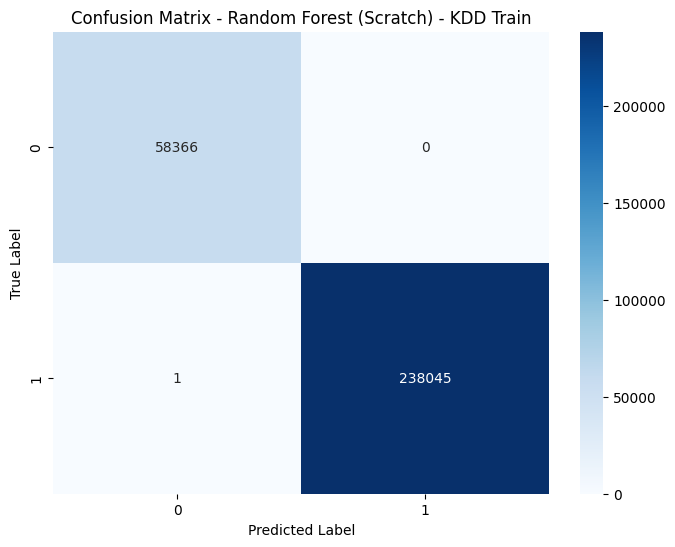

Random Forest (Scratch) - KDD Validation Performance:
Accuracy: 0.9998
Precision: 0.9999
Recall: 0.9998
F1 Score: 0.9999


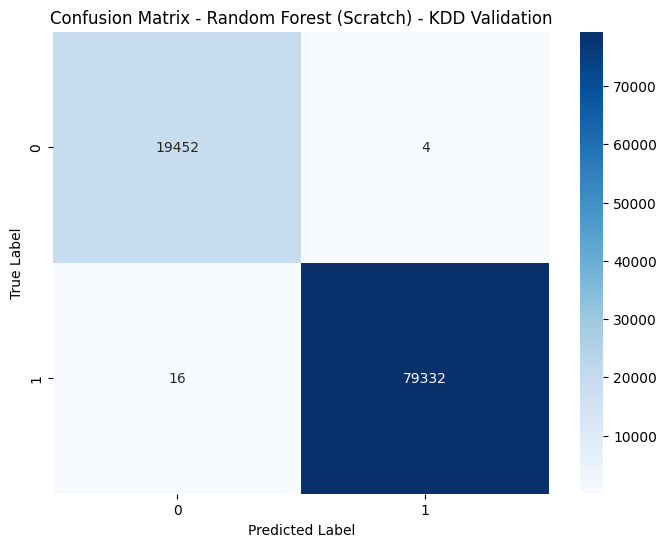

Random Forest (Scratch) - KDD Test Performance:
Accuracy: 0.9998
Precision: 0.9999
Recall: 0.9998
F1 Score: 0.9999


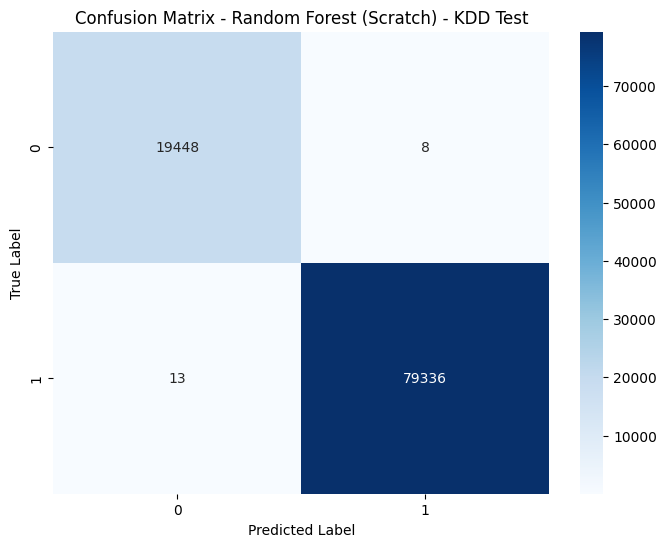

Best Parameters for Sklearn RF - KDD: {'n_estimators': 20, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}
Random Forest (Sklearn) - KDD Train Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


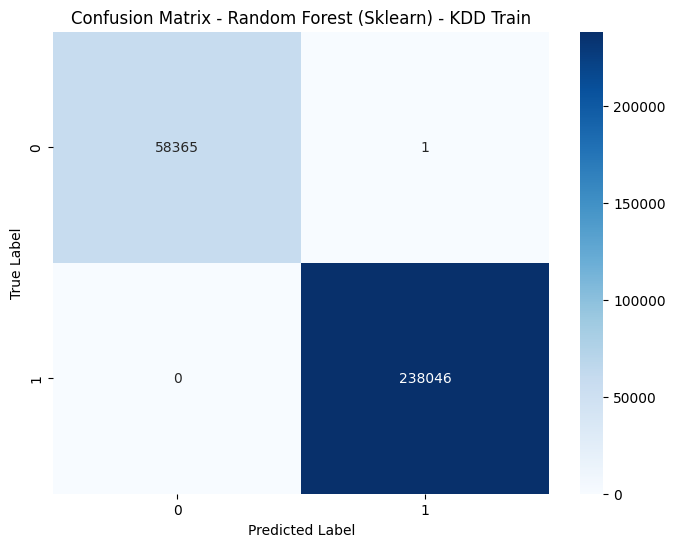

Random Forest (Sklearn) - KDD Validation Performance:
Accuracy: 0.9998
Precision: 1.0000
Recall: 0.9998
F1 Score: 0.9999


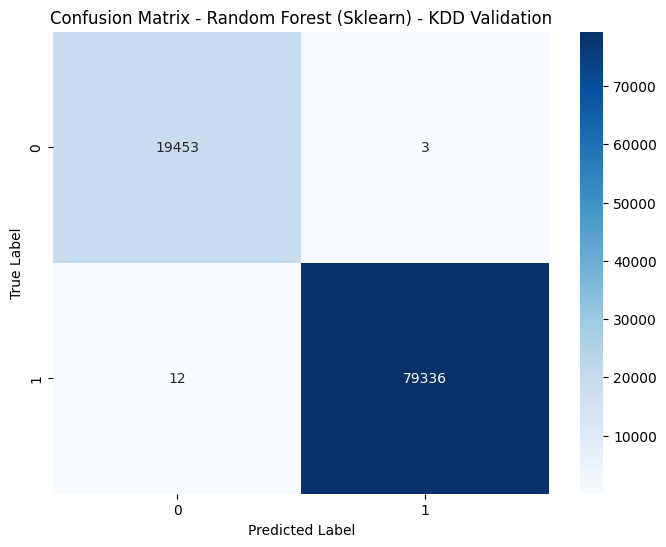

Random Forest (Sklearn) - KDD Test Performance:
Accuracy: 0.9998
Precision: 0.9999
Recall: 0.9998
F1 Score: 0.9998


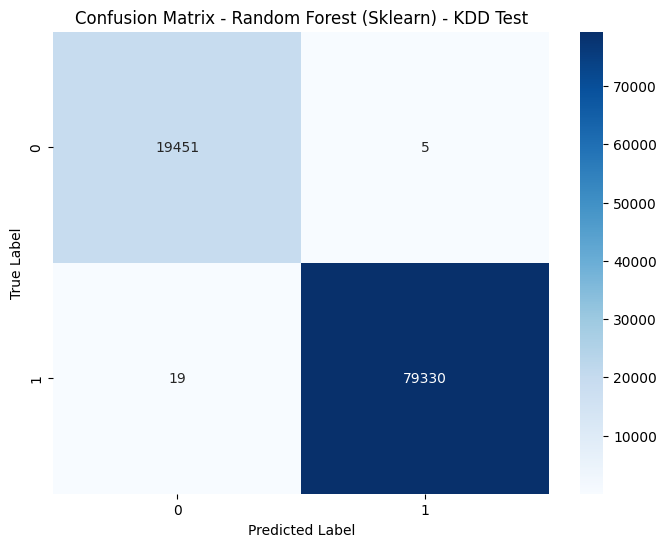

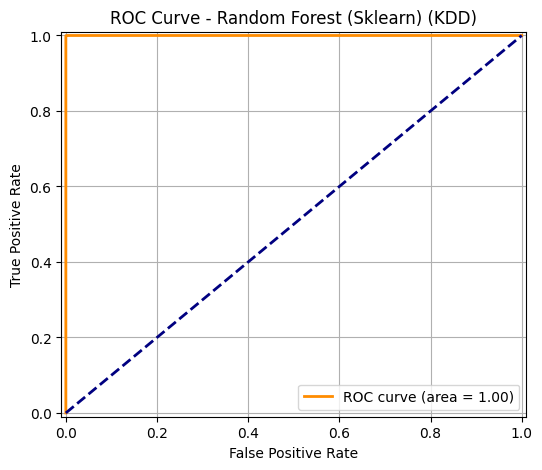

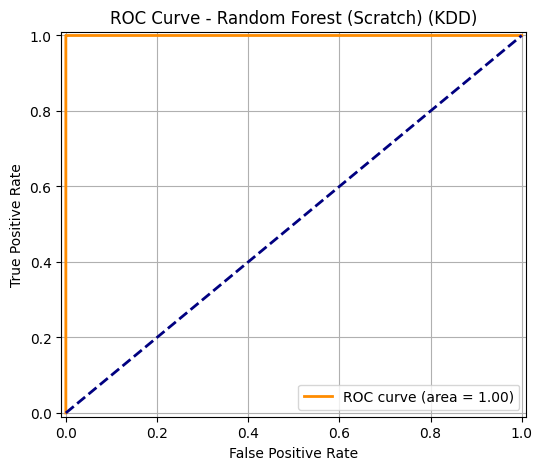

In [ ]:
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [True]
}

# Train custom Random Forest
rf_scratch_best, rf_scratch_params_kdd, val_score_scratch = manual_grid_search(
    RandomForestScratch, param_grid, X_train_kdd, y_train_kdd, X_val_kdd, y_val_kdd
)
print("Best Parameters for Custom RF (Scratch) - KDD:", rf_scratch_params_kdd)

# Predict and Evaluate
evaluate(y_train_kdd, rf_scratch_best.predict(X_train_kdd), "Random Forest (Scratch) - KDD Train")
evaluate(y_val_kdd, rf_scratch_best.predict(X_val_kdd), "Random Forest (Scratch) - KDD Validation")
evaluate(y_test_kdd, rf_scratch_best.predict(X_test_kdd), "Random Forest (Scratch) - KDD Test")


# 5. Sklearn Random Forest
rf_sklearn_best, rf_sklearn_params_kdd, val_score_sklearn = manual_grid_search(
    RandomForestClassifier, param_grid, X_train_kdd, y_train_kdd, X_val_kdd, y_val_kdd
)
print("Best Parameters for Sklearn RF - KDD:", rf_sklearn_params_kdd)

# Predict and Evaluate
evaluate(y_train_kdd, rf_sklearn_best.predict(X_train_kdd), "Random Forest (Sklearn) - KDD Train")
evaluate(y_val_kdd, rf_sklearn_best.predict(X_val_kdd), "Random Forest (Sklearn) - KDD Validation")
evaluate(y_test_kdd, rf_sklearn_best.predict(X_test_kdd), "Random Forest (Sklearn) - KDD Test")

# ROC Curve for Scratch Random Forest
y_scores_kdd_sklearn = rf_sklearn_best.predict_proba(X_test_kdd)[:, 1]
plot_roc_curve(y_test_kdd, y_scores_kdd_sklearn, "Random Forest (Sklearn)", "KDD")

# ROC Curve for Scratch Random Forest
y_scores_kdd_scratch = rf_scratch_best.predict_proba(X_test_kdd)[:, 1]
plot_roc_curve(y_test_kdd, y_scores_kdd_scratch, "Random Forest (Scratch)", "KDD")

# **Training the RF Models(both from sklearn and from scratch) and Finding out the performance metrics on NSL-KDD**

Best Parameters for Custom RF (Scratch): {'n_estimators': 30, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}
Random Forest (Scratch) - Train Performance:
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F1 Score: 0.9999


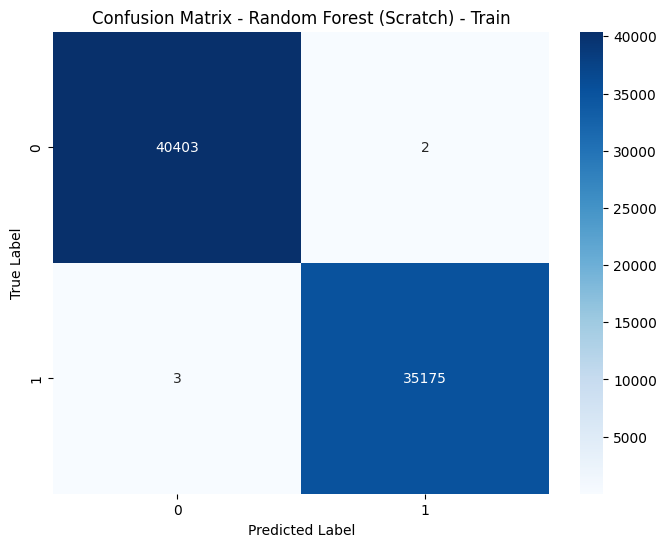

Random Forest (Scratch) - Validation Performance:
Accuracy: 0.9986
Precision: 0.9994
Recall: 0.9975
F1 Score: 0.9985


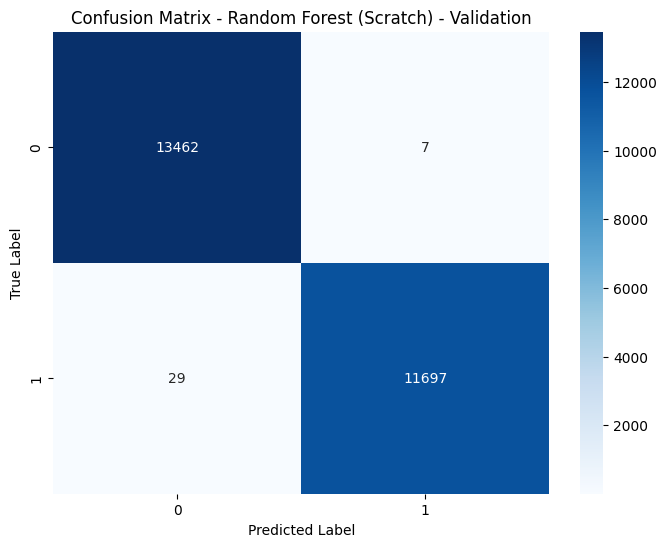

Random Forest (Scratch) - Test Performance:
Accuracy: 0.9990
Precision: 0.9997
Recall: 0.9981
F1 Score: 0.9989


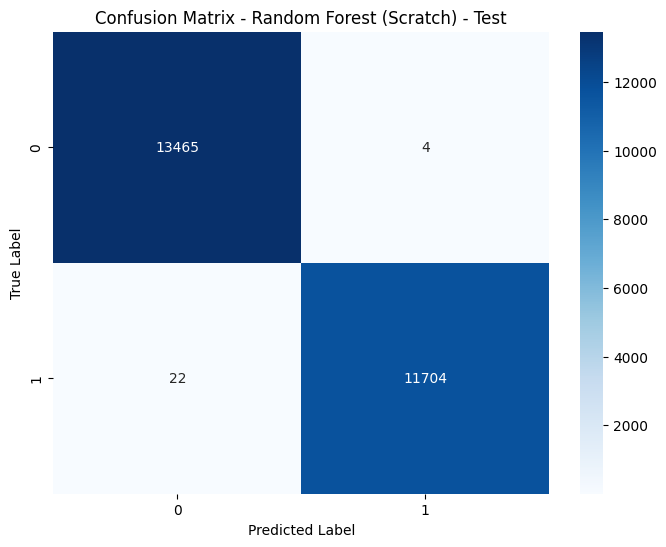

Best Parameters for Sklearn RF: {'n_estimators': 10, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': True}
Random Forest (Sklearn) - Train Performance:
Accuracy: 0.9999
Precision: 1.0000
Recall: 0.9998
F1 Score: 0.9999


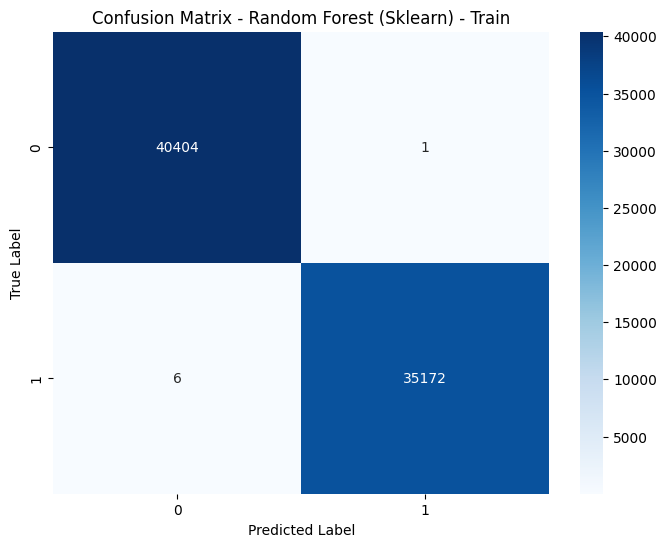

Random Forest (Sklearn) - Validation Performance:
Accuracy: 0.9984
Precision: 0.9994
Recall: 0.9971
F1 Score: 0.9982


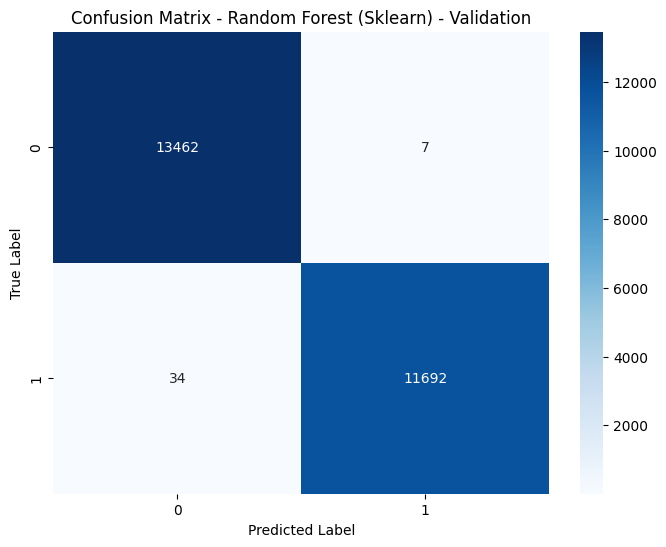

Random Forest (Sklearn) - Test Performance:
Accuracy: 0.9983
Precision: 0.9995
Recall: 0.9969
F1 Score: 0.9982


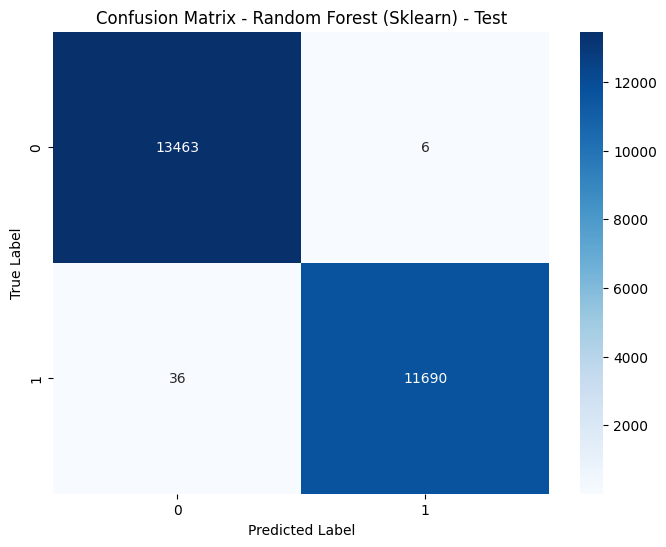

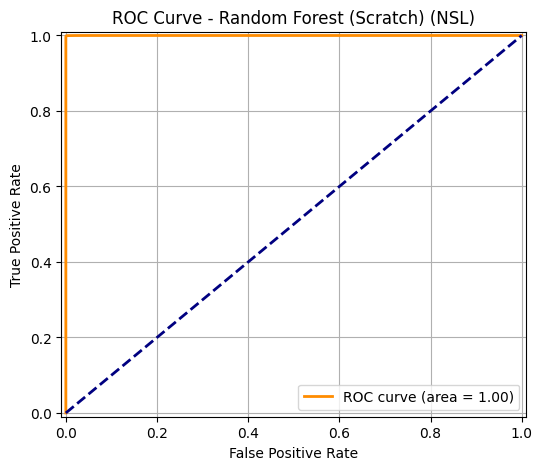

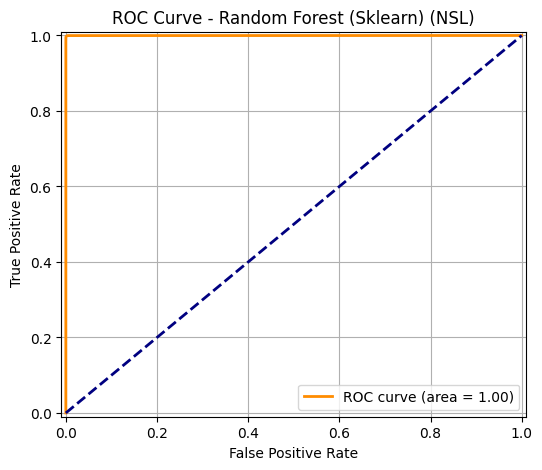

In [ ]:
# For Scratch Random Forest
rf_scratch_best, rf_scratch_params, scratch_val_score = manual_grid_search(
    RandomForestScratch, param_grid, X_train_nsl, y_train_nsl, X_val_nsl, y_val_nsl
)
print("Best Parameters for Custom RF (Scratch):", rf_scratch_params)

# Predict
y_train_pred_scratch = rf_scratch_best.predict(X_train_nsl)
y_val_pred_scratch = rf_scratch_best.predict(X_val_nsl)
y_test_pred_scratch = rf_scratch_best.predict(X_test_nsl)

# Evaluate
evaluate(y_train_nsl, y_train_pred_scratch, "Random Forest (Scratch) - Train")
evaluate(y_val_nsl, y_val_pred_scratch, "Random Forest (Scratch) - Validation")
evaluate(y_test_nsl, y_test_pred_scratch, "Random Forest (Scratch) - Test")


# For sklearn Random Forest
rf_sklearn_best, rf_sklearn_params, sklearn_val_score = manual_grid_search(
    RandomForestClassifier, param_grid, X_train_nsl, y_train_nsl, X_val_nsl, y_val_nsl
)
print("Best Parameters for Sklearn RF:", rf_sklearn_params)

# Predict
y_train_pred_sklearn = rf_sklearn_best.predict(X_train_nsl)
y_val_pred_sklearn = rf_sklearn_best.predict(X_val_nsl)
y_test_pred_sklearn = rf_sklearn_best.predict(X_test_nsl)

# Evaluate
evaluate(y_train_nsl, y_train_pred_sklearn, "Random Forest (Sklearn) - Train")
evaluate(y_val_nsl, y_val_pred_sklearn, "Random Forest (Sklearn) - Validation")
evaluate(y_test_nsl, y_test_pred_sklearn, "Random Forest (Sklearn) - Test")

# ROC Curve for Scratch Random Forest
y_scores_nsl_scratch = rf_scratch_best.predict_proba(X_test_nsl)[:, 1]
plot_roc_curve(y_test_nsl, y_scores_nsl_scratch, "Random Forest (Scratch)", "NSL")

# ROC Curve for Sklearn Random Forest
y_scores_nsl_sklearn = rf_sklearn_best.predict_proba(X_test_nsl)[:, 1]
plot_roc_curve(y_test_nsl, y_scores_nsl_sklearn, "Random Forest (Sklearn)", "NSL")